# Flux Gate Approach to Mass Balance

This code executes a flux gate approach to glacier mass balance given: 

- elevation change
- ice thickness
- surface velocity
- glacier outline

A GUI is used to create flux gates and determine the elevation change and ice flux through the gate. The code is executed as follows:

1. Locate data files
2. Resample, reproject, and clip files to the same resolution, coordinate system, and extent
3. Draw desired flux gates using the GUI
4. Calculate ice volume through the flux gates

In [104]:
from tkinter import *
import os, warnings, math, rasterio, shapely
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString
from shapely.ops import split
import rioxarray as rxr
from rasterio.warp import Resampling
import matplotlib.pyplot as plt

from raster_basics.RasterBasics import shpReprojection, shpClip, tifReprojectionResample
from raster_basics.RasterBasics import extract_along_line, end_points

In [105]:
warnings.filterwarnings('ignore', category=FutureWarning)

### Import and Prepare Files

In [83]:
# gulkana outline file (make sure this is in the right crs)
# shp_fp = '/Users/albinwells/Desktop/GlacierMB/Gulkana/gulkana.shp' # RGI outline
shp_fp = '/Users/albinwells/Desktop/GlacierMB/Other/Gulkana_USGS_2021.shp' # 2021 USGS outline


In [84]:
# locate filepaths
dhdt_fp_init = '/Users/albinwells/Desktop/GlacierMB/Gulkana/dhdt_GulkanaRegion.tif'
h_fp_init = '/Users/albinwells/Desktop/GlacierMB/Gulkana/Gulkana_Thickness_Millan.tif'
vx_fp_init = '/Users/albinwells/Desktop/GlacierMB/Gulkana/00570_MillanVelocity_2017-2018_vx.tif'
vy_fp_init = '/Users/albinwells/Desktop/GlacierMB/Gulkana/00570_MillanVelocity_2017-2018_vy.tif'

# output filepaths
dhdt_fp = 'dhdt_fluxgate.tif' # output filename
h_fp = 'h_fluxgate.tif' 
vx_fp = 'vx_fluxgate.tif' 
vy_fp = 'vy_fluxgate.tif'


In [85]:
crs = 'EPSG:32606'  # UTM zone 6N
res = 20 # output pixel resolution (m)


In [86]:
# temporary clipping for larger files
dhdt_temp_fp = 'dhdt_temp_clip.tif'
shpClip(dhdt_fp_init, shp_fp, dhdt_temp_fp, pad_size=10)

# resample and reproject all files to same extent
tifReprojectionResample(dhdt_temp_fp, dhdt_fp, crs, res, Resampling.cubic_spline, extent_file=vx_fp_init)
tifReprojectionResample(h_fp_init, h_fp, crs, res, Resampling.cubic_spline, extent_file=vx_fp_init)
tifReprojectionResample(vx_fp_init, vx_fp, crs, res, Resampling.cubic_spline, extent_file=vx_fp_init)
tifReprojectionResample(vy_fp_init, vy_fp, crs, res, Resampling.cubic_spline, extent_file=vx_fp_init)

# clip by the shapefile to such that off-glacier terrain has nan values
shpClip(dhdt_fp, shp_fp, dhdt_fp, nan_val=-9999, crop=False)
shpClip(h_fp, shp_fp, h_fp, nan_val=-9999, crop=False)
shpClip(vx_fp, shp_fp, vx_fp, nan_val=-9999, crop=False)
shpClip(vy_fp, shp_fp, vy_fp, nan_val=-9999, crop=False)

# remove temporary files
os.remove(dhdt_temp_fp) 

### Draw Flux Gates

In [115]:
class FluxGate:
    def __init__(self):
        self.vCol = 0.8
        self.stored_xvals = []
        self.stored_yvals = []
        self.asci = 64        
        self.asci_list = []
        self.temp_asci = []
        self.points_i = 0
        
        self.geotiff_vals_list = []
        self.geotiff_dist_list = []
        self.geotiff_vals1_list = []
        self.geotiff_vals2_list = []
        self.geotiff_vals3_list = []
        
        self.p_shp = 'partitioned_shp.shp'

    def sample_on_line(self, geotiff, shp, vmin, vmax, cmap, clabel, title, nan_val=-9999,
                       geotiff_calc1=None, geotiff_calc2=None, geotiff_calc3=None):
        # a gui to create a transect
        %matplotlib tk
        fig, ax = plt.subplots(nrows=1, ncols=1)
        fig.set_size_inches(16, 10)

        # create a new shapefile
        gpd.read_file(shp).to_file(self.p_shp)
        
        # print and store selected values
        def onclick(event): # mouse click event
            self.asci += 1
            self.points_i += 1
            self.temp_asci.append(chr(self.asci))
            ix, iy = event.xdata, event.ydata
            self.stored_xvals.append(ix)
            self.stored_yvals.append(iy) 

            plt.autoscale(False)
            plt.plot(self.stored_xvals, self.stored_yvals, color='orangered', zorder=10) 
            plt.plot(ix, iy, color='r', marker='.', markersize=8, zorder=10)
            ax.annotate(chr(self.asci), (ix+15, iy+15), color='r', fontsize=16, zorder=20)
            plt.show()
            plt.savefig('Sampling along a line.jpg', dpi=300)
            
        def on_return_key(event):
            self.asci_list.append(self.temp_asci) # save our transect labels
            
            # every gate (after hitting 'return') sample along the line. then, reset values
            geotiff_vals, geotiff_dist = flux_gate.vals_along_line(geotiff, nan_val)
            geotiff_vals1, d1 = flux_gate.vals_along_line(geotiff_calc1, nan_val)
            geotiff_vals2, d2 = flux_gate.vals_along_line(geotiff_calc2, nan_val)
            geotiff_vals3, d3 = flux_gate.vals_along_line(geotiff_calc3, nan_val)

            self.geotiff_vals_list.append(geotiff_vals) # save our distance and value pairs
            self.geotiff_dist_list.append(geotiff_dist)
            self.geotiff_vals1_list.append(geotiff_vals1)
            self.geotiff_vals2_list.append(geotiff_vals2) 
            self.geotiff_vals3_list.append(geotiff_vals3)

            try:
                flux_gate.partition_shp()
            finally:
                self.stored_xvals = [] # reset stored x and y values
                self.stored_yvals = []
                self.temp_asci = []

        cid = fig.canvas.mpl_connect('button_press_event', onclick) # initiate the button click event
        cid2 = fig.canvas.mpl_connect('key_press_event', on_return_key) # initiate the Return (Enter) key event

        # background plot
        tiff = rasterio.open(geotiff)
        rast_bounds = tiff.bounds # left, bottom, right, top
        tiff_array = tiff.read(1)
        tiff_array[tiff_array == nan_val] = np.nan
        
        c = ax.imshow(tiff_array, cmap=cmap, vmin=vmin, vmax=vmax) # plot mosaic
        plt.imshow(tiff_array, cmap=cmap, vmin=vmin, vmax=vmax,
                   extent=[rast_bounds[0], rast_bounds[2], rast_bounds[1], rast_bounds[3]])
        plt.grid()
        fig.colorbar(c, label=clabel, ax=ax)

        gdf = gpd.read_file(shp)
        gdf.plot(ax=ax, edgecolor='k', facecolor='none')
        ax.set_xlim(rast_bounds[0], rast_bounds[2])
        ax.set_ylim(rast_bounds[1], rast_bounds[3])
#         ax.text((rast_bounds[0]+rast_bounds[2])/2, rast_bounds[1], 
#                 'Click to make a flux gate\nPress any button to complete the gate and start a new one', 
#                 fontsize=10, color='g', va='bottom', ha='center')
        print('Click to make a flux gate\nPress any button to complete the gate and start a new one')

        plt.xlabel('UTM Easting (m)', fontsize=12)
        plt.ylabel('UTM Northing (m)', fontsize=12)
        plt.title(title, fontsize=24, c='k')
        plt.show()
        
    def vals_along_line(self, tiff, offglacier_val):
        # extract raster values along the line
        line_points = list(zip(self.stored_xvals, self.stored_yvals))
        line = shapely.geometry.MultiLineString([[[p[0],p[1]] for p in line_points]])
        xarr = rxr.open_rasterio(tiff).squeeze()
        profile, coordinate = extract_along_line(xarr, line)
        points = end_points(xarr, line_points)

        # get the raster values along the line and the distances along the transect
        vals = [float(x) for x in profile]
        line_dists = [[coordinate[i], coordinate[i+1]] for i in range(len(coordinate)-1)]
        dist = [math.dist(pair[0], pair[1]) for pair in line_dists]
        dist = [sum(dist[:i]) for i in range(len(dist)+1)]

        # remove off-glacier values
        vals_filt, dist_filt = flux_gate.remove_offglacier(vals, dist, offglacier_val)
        return vals_filt, dist_filt
    
    def remove_offglacier(self, vals, dist, removal_val):
        # remove off-glacier values from list
        vals_filt = [v for v in vals if v != removal_val]
        dist_temp = [d for v, d in zip(vals, dist) if v != removal_val]
        dist_filt = [d - dist_temp[0] for d in dist_temp]
        return vals_filt, dist_filt
    
    def partition_shp(self):
        shp_gdf = gpd.read_file(self.p_shp) # get the input shapefile
        line = LineString([(x, y) for x, y in zip(self.stored_xvals, self.stored_yvals)]) # line from flux gate
        partitioned_geometries = shp_gdf['geometry'].apply(lambda geom: split(geom, line)) # split shapefile geometry
        partitioned_gdf = gpd.GeoDataFrame(geometry=partitioned_geometries.explode(index_parts=False))
        partitioned_gdf.to_file(self.p_shp) # save file


In [116]:
flux_gate = FluxGate()
flux_gate.sample_on_line(geotiff=dhdt_fp, shp=shp_fp, vmin=-5, vmax=5, cmap='RdBu', clabel='Elevation Change (m/yr)', 
                         title='Gulkana Flux Gates', nan_val=-9999, 
                         geotiff_calc1=h_fp, geotiff_calc2=vx_fp, geotiff_calc3=vy_fp)


Click to make a flux gate
Press any button to complete the gate and start a new one


### Calculate Flux Gate Values

NOTE: we assume flow is perpendicular to the flux gate

In [117]:
def incremental_dist(dist):
    # get the distance represented by each point along our flux gate
    divider_dist = [(dist[i] + dist[i+1])/2 for i in range(len(dist)-1)]
    divider_dist.insert(0, dist[0])
    divider_dist.append(dist[-1])
    
    # incremental distance between values
    inc_dist = [divider_dist[i+1] - divider_dist[i] for i in range(len(divider_dist)-1)]  
    assert sum(inc_dist) == dist[-1], 'Issue with inc_dist. Sum of incremental distance must equal total distance'
    return inc_dist

In [118]:
for i in range(len(flux_gate.geotiff_vals_list)): 
    
    # get the distance values
    dist_i = flux_gate.geotiff_dist_list[i] 
    inc_dist_i = incremental_dist(dist_i)
    
    # get all of the data values
    dhdt_i = flux_gate.geotiff_vals_list[i]
    h_i = flux_gate.geotiff_vals1_list[i]
    vx_i = flux_gate.geotiff_vals2_list[i]
    vy_i = flux_gate.geotiff_vals3_list[i]
    v_i = [((vx*flux_gate.vCol)**2 + (vy*flux_gate.vCol)**2)**0.5 for vx, vy in zip(vx_i, vy_i)]
    
    # label the gate
    gate_str = ''
    for gate_lab in flux_gate.asci_list[i]:
        gate_str += gate_lab
        gate_str += ' - '
    print('Gate', gate_str[:-3])
    
    # flux gate calculation
    vhd_i = [v*h*d for v, h, d in zip(v_i, h_i, inc_dist_i)]
    total_vhd_i = sum(vhd_i)
    print('\tVol. ice flux (m^3/yr):\t', round(total_vhd_i))
    
    # mean elevation change
    d_dhdt_i = [dhdt*d for dhdt, d in zip(dhdt_i, inc_dist_i)]
    total_dhdt_i = sum(d_dhdt_i)
    mean_dhdt_i = total_dhdt_i/dist_i[-1]
    print('\tVol. ice change (m^3/yr):', round(total_dhdt_i))
    print('\tMean dhdt (m/yr):\t', round(mean_dhdt_i, 2))
    
    # mean ice thickness
    dh_i = [h*d for h, d in zip(h_i, inc_dist_i)]
    mean_h_i = sum(dh_i)/dist_i[-1]
    print('\tMean thickness (m):\t', round(mean_h_i, 1))
    
    # mean velocity
    dv_i = [v*d for v, d in zip(v_i, inc_dist_i)]
    mean_v_i = sum(dv_i)/dist_i[-1]
    print('\tMean velocity (m/yr):\t', round(mean_v_i, 2))
    
    # total gate length
    print('\tGate length (m):\t', round(dist_i[-1]), '\n')
    

Gate A - B
	Vol. ice flux (m^3/yr):	 1007087
	Vol. ice change (m^3/yr): -1051
	Mean dhdt (m/yr):	 -1.55
	Mean thickness (m):	 133.9
	Mean velocity (m/yr):	 9.78
	Gate length (m):	 679 

Gate C - D
	Vol. ice flux (m^3/yr):	 1705798
	Vol. ice change (m^3/yr): -1154
	Mean dhdt (m/yr):	 -1.27
	Mean thickness (m):	 155.3
	Mean velocity (m/yr):	 9.7
	Gate length (m):	 907 

Gate E - F
	Vol. ice flux (m^3/yr):	 2157380
	Vol. ice change (m^3/yr): -1415
	Mean dhdt (m/yr):	 -1.31
	Mean thickness (m):	 121.7
	Mean velocity (m/yr):	 12.64
	Gate length (m):	 1080 



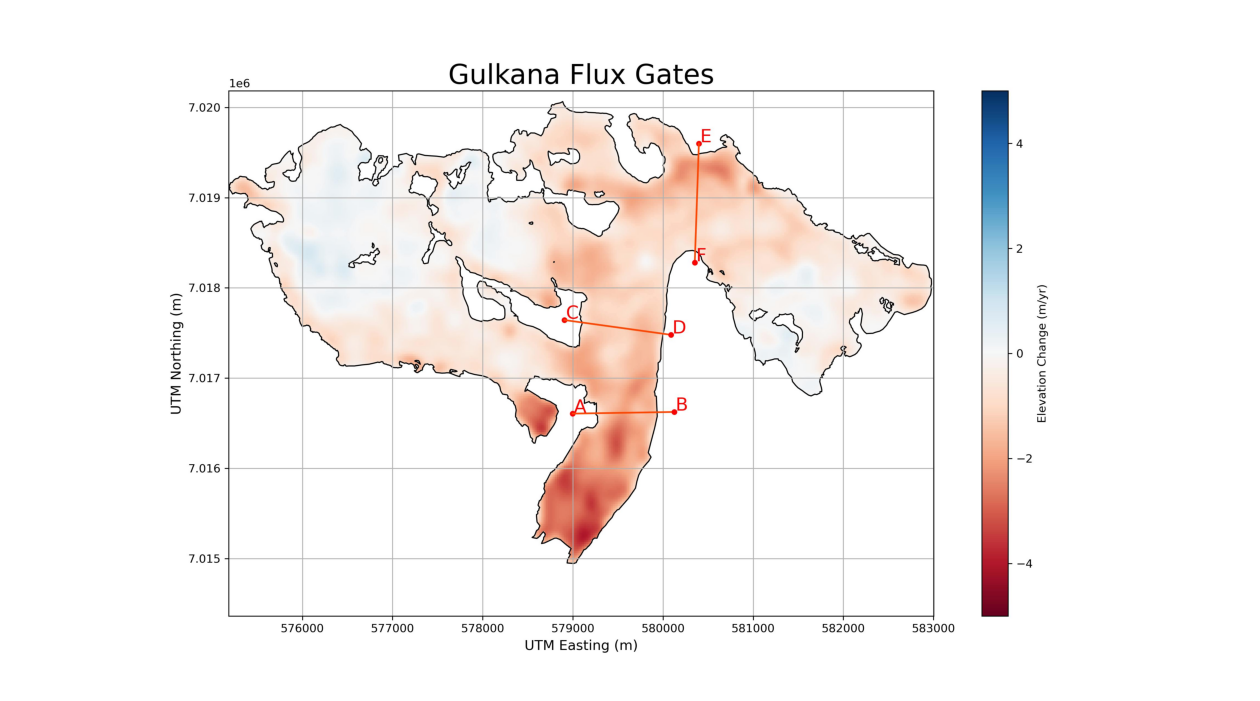

In [119]:
# plot the results
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
pic = plt.imread('Sampling along a line.jpg')
ax.axis('off')
ax.imshow(pic)


The volume of ice through flux gates should, theoretically, conserve mass. Thus, the (sum of the) volume of ice through upstream gate(s) should equal the volume of ice through the downstream gate, minus any mass change (climatic mass balance):

<center>$V_{in}=V_{out}+V_{cmb}$</center>


Total Area:	15.49 sq.km
A1 Area:	10.71 sq.km
A2 Area:	3.54 sq.km
A3 Area:	1.25 sq.km


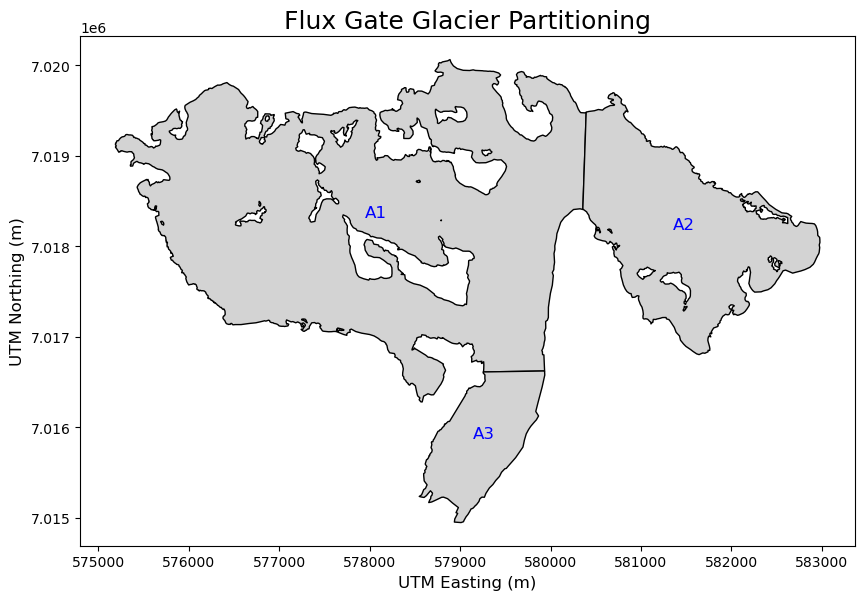

In [120]:
# area from each flux gate
gdf = gpd.read_file(flux_gate.p_shp)
individual_areas = gdf.geometry.area # area (sq. m)
total_area = individual_areas.sum() # total area (sq. m)
print(f"Total Area:\t{(total_area/1e6):.2f} sq.km")
for index, area in enumerate(individual_areas):
    print(f"A{index + 1} Area:\t{(area/1e6):.2f} sq.km")

# show a plot of the flux gate partitions
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, edgecolor='k', facecolor='lightgrey')

# label the geometries
for idx, row in gdf.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(f"A{idx+1}", (centroid.x-100, centroid.y), fontsize=12, color='blue')

plt.xlabel('UTM Easting (m)', fontsize=12)
plt.ylabel('UTM Northing (m)', fontsize=12)
plt.title('Flux Gate Glacier Partitioning', fontsize=18, c='k')
plt.show()


In [114]:
a2_in = 3343828 # ice volume in (m3/yr)
a2_out = 2223509 # ice volume out (m3/yr)
a2_area = individual_areas[1] # area (m2)
a2_divQ = (a2_in - a2_out)/a2_area
print('Calculated CMB in A2 (lowering, m/yr):', round(a2_divQ, 3)) # weird to have emergence here

# our flux gates have mean TMB of -1.34 and -0.85 (mean -1.10). To get to -1.787, we need ~0.7 m/yr EMERGENCE

Calculated CMB in A2 (lowering, m/yr): 0.315


In [76]:
a5_in = 761518 # ice volume in (m3/yr)
a5_out = 624288 # ice volume out (m3/yr)
a5_area = individual_areas[4] # area (m2)
a5_divQ = (a5_in - a5_out)/a5_area
print('Calculated CMB in A5 (lowering, m/yr):', round(a5_divQ, 3)) # low flux volume mean low emergence

# our flux gates have mean TMB of -3.0 and -2.77 (mean -2.89). To get to -0.306, we need ~2.6 m/yr EMERGENCE

Calculated CMB in A5 (lowering, m/yr): 0.02


### Remove unnecessary files

In [77]:
os.remove(dhdt_fp)
os.remove(h_fp)
os.remove(vx_fp)
os.remove(vy_fp)
# os.remove(shp_fp)

In [78]:
os.remove(flux_gate.p_shp)
os.remove(flux_gate.p_shp[:-3]+'cpg')
os.remove(flux_gate.p_shp[:-3]+'dbf')
os.remove(flux_gate.p_shp[:-3]+'prj')
os.remove(flux_gate.p_shp[:-3]+'shx')
